## Importing Necessary Libraries and Making Initial Configurations
---

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import soundfile as sf
import scipy.signal as signal

from glob import glob

import librosa
import IPython.display as ipd

import math

## Sampling and Plotting Functions
---

### Filename identifiers

 - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

 - Vocal channel (01 = speech, 02 = song).
 
 - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
 
 - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
 
 - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
 
 - Repetition (01 = 1st repetition, 02 = 2nd repetition).
 
 - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

### RAVDESS Sampling Function

 - allows for customized querying of the RAVDESS dataset based on desired feature types


In [3]:
### DIRECTORY SPECIFIED IN PATH MUST HAVE THE SAME STRUCTURE AS ORIGINAL RAVDESS DATASET ###
# pass custom tuples in order to specify the desired feature types
# specifying only the path will include everything
def get_RAVDESS_sample(path, modality: tuple = (1,2,3),
                             voice_channel: tuple = (1,2),
                             emotion: tuple = tuple(range(1,9)),
                             intensity: tuple = (1,2),
                             statement: tuple = (1,2),
                             repetition: tuple = (1,2),
                             actor: tuple = tuple(range(1,25))):
    
    m = "".join(str(s) for s in modality)
    vc = "".join(str(s) for s in voice_channel)
    e = "".join(str(s) for s in emotion)
    i = "".join(str(s) for s in intensity)
    s = "".join(str(s) for s in statement)
    r = "".join(str(s) for s in repetition)

    actor = set(actor)
    
    dirs = []
    
    if(path[-1] == '/'):
        adirs = path+"Actor_*"
    else:
        adirs = path+"/Actor_*"
                
    for d in glob(adirs):
        if (int(d[-2]+d[-1]) in actor):
            dirs.append(d)

    files = []
    for d in dirs:
        d = d+"/"
        
        for f in glob(d+f"0[{m}]-0[{vc}]-0[{e}]-0[{i}]-0[{s}]-0[{r}]-*"):    
            files.append(f)
    
    audio = []
    for f in files:
        path = f
        signal, sr = librosa.load(f, sr=None, mono=True)
        name = str.split(f, sep='/')[-1]
        audio.append([signal, sr, name, path])
    
    return audio

    

### Audio Signal Plotting Function

- uses a digital signal and its corresponding sample rate to plot an amplitude vs time graph

In [4]:
# signal plotting function
def plot_signal(signal, sample_rate, plot_title = "Audio Signal", spect=False):
    
    if spect == False:
        df = pd.DataFrame({
            'signals' : signal,
            'seconds' : [i/sample_rate for i in range(0, len(signal))]
        })
        df.plot(y="signals", x="seconds", figsize=(15,5), lw=0.1, title=plot_title, xlabel="seconds", ylabel="amplitude")
    
    else:
        gram = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(gram, sr=sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(plot_title)
        plt.show()
        

## Normalizing Sound Files by Average Power Level
---

The average power level of a digital signal is the sum of squares of all samples divided by the number of samples. To normalize, we determine the average power level of each audio file in the sample dataset and then calculate the overall mean of all averages. Each digital signal in the sample is then scaled up or down in order to match its power level to the overall mean.

### Loading all audio files

In [5]:
#all_audio_files = get_RAVDESS_sample("./sound_files")

### Calculating Overall average power level for all audio files

In [6]:
# this will determine the overall average power level of the dataset
#   signals with P_avg below this overall average will be scaled up, else scaled down
# total_avgs = 0
# for a in all_audio_files:
#     total_avgs += sum(a[1]**2)/len(a[1])
# overall_P_avg = total_avgs/len(all_audio_files)
# print(f"Overall average = {overall_P_avg}")

overall_P_avg = 0.0008270979304005066

### Extracting Loud/Soft Sample Audio Files for Testing

In [7]:
# ***IGNORE THIS CELL*** EXTRACTING SINGLE AUDIO FILE FROM ENTIRE DATASET ***IGNORE THIS CELL***

# LOUD FILE
"03-01-03-02-02-01-10.wav"

# for a in all_audio_files:
#     if a[0] == "03-01-05-02-02-01-13.wav":
#         loud_audio = copy.deepcopy(a)

# # # QUIET FILE
# # '03-01-02-02-02-01-05.wav'
# for a in all_audio_files:
#     if a[0] == "03-01-02-01-02-01-04.wav":
#         quiet_audio = copy.deepcopy(a)

'03-01-03-02-02-01-10.wav'

In [8]:
# LOUD FILE
"loud_audio.wav"

loud_audio_signal, loud_audio_sr = librosa.load("./loud_audio.wav", sr=None, mono=True)
loud_audio = [loud_audio_signal, loud_audio_sr]

# # QUIET FILE
# 'quiet_audio.wav'
quiet_audio_signal, quiet_audio_sr = librosa.load("./quiet_audio.wav", sr=None, mono=True)
quiet_audio = [quiet_audio_signal, quiet_audio_sr]

### Visualizing Test File

#### Before Scaling

Average Power Level: 5.166052687854972e-06
dB Compared to RAVDESS Average: -22.043981029476566
Original Audio: 


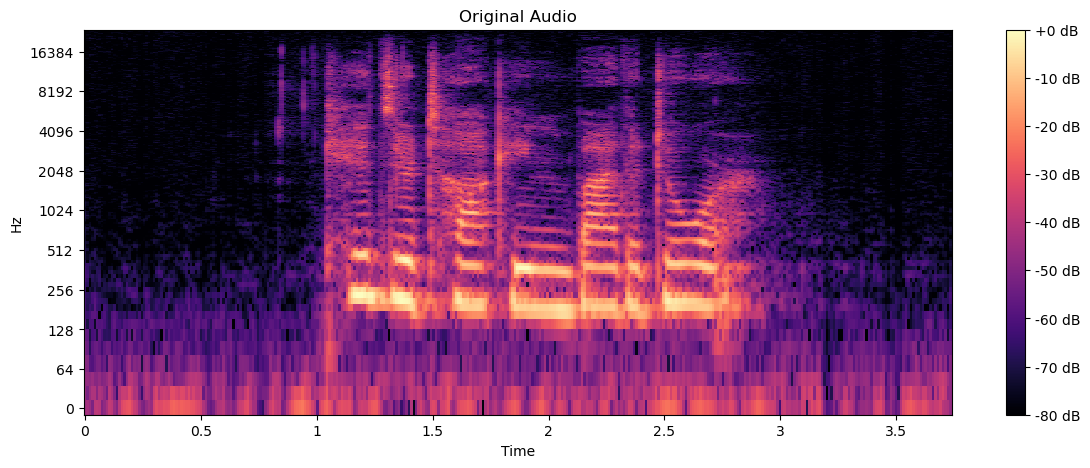

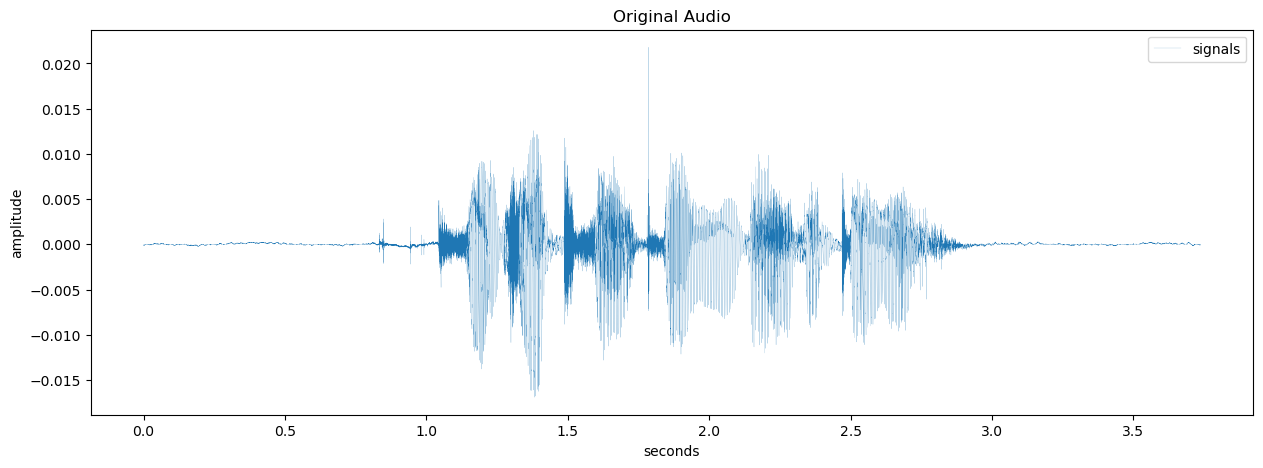

In [30]:
testfile = quiet_audio

print(f"Average Power Level: {np.mean(testfile[0]**2)}")
print(f"dB Compared to RAVDESS Average: {10*np.log10(np.mean(testfile[0]**2)/overall_P_avg)}")

sf.write("./output/original_audio.wav", testfile[0], testfile[1])
print("Original Audio: ")
ipd.display(ipd.Audio("./output/original_audio.wav"))

# plotting original audio
plot_signal(testfile[0],testfile[1], "Original Audio", spect=True)
plot_signal(testfile[0],testfile[1], "Original Audio")

#### Scaling Test Audio

In [31]:
# scaling audio file
scale_factor = math.sqrt( (overall_P_avg*len(testfile[0])) / (sum(testfile[0]**2)) )
testfile[0] *= scale_factor

#### After Scaling

Average Power Level: 0.0008270980906672776
dB Compared to RAVDESS Average: 8.415323622860367e-07
Scaled Audio:


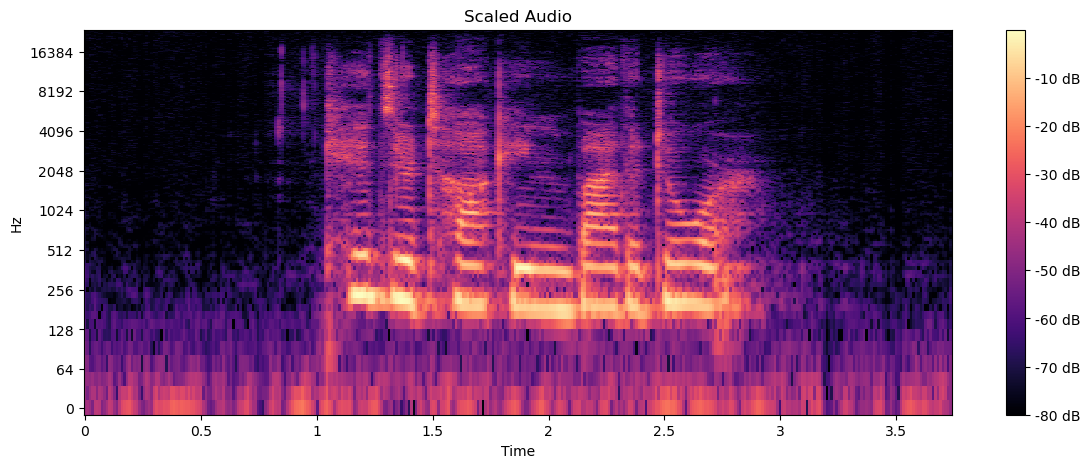

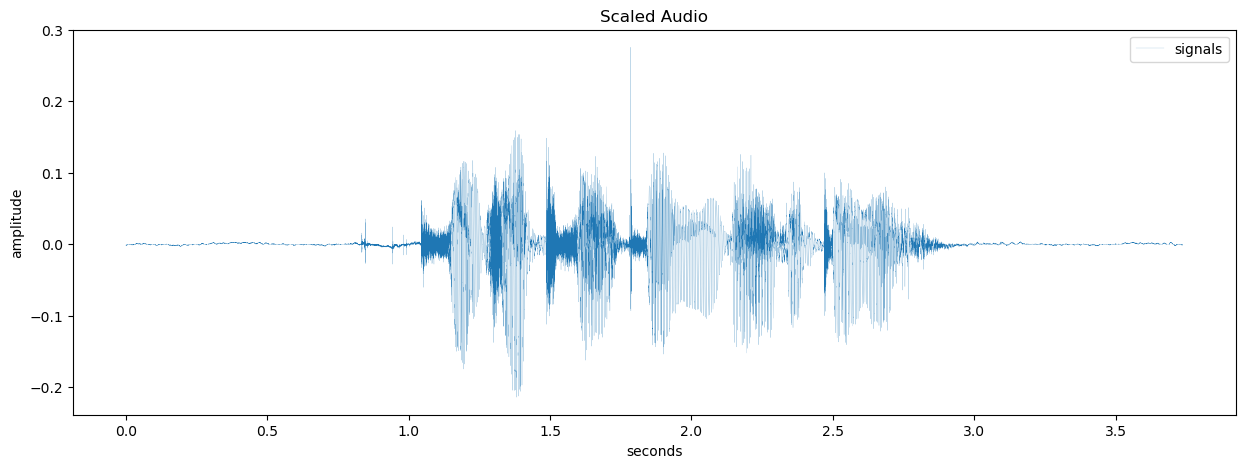

In [32]:
print(f"Average Power Level: {np.mean(testfile[0]**2)}")
print(f"dB Compared to RAVDESS Average: {10*np.log10(np.mean(testfile[0]**2)/overall_P_avg)}")

sf.write("./output/scaled_audio.wav", testfile[0], testfile[1])
print("Scaled Audio:")
ipd.display(ipd.Audio("./output/scaled_audio.wav"))

# plotting scaled audio
plot_signal(testfile[0],testfile[1], "Scaled Audio", spect=True)
plot_signal(testfile[0],testfile[1], "Scaled Audio")

## Experiment Sampling Method
---

The goal was to extract a sample from the dataset that was significantly smaller in size and computationally inexpensive, while preserving the original dataset's variability.

All emotional variations and intensities for the first repetition of a single statement were extracted. For statement 1, data came from the first half of the dataset (Actors 1-12), and for statement 2 data came from the second half (Actors 13-24). This ensured that variability across emotion type, emotional intensity and actor gender was retained. Furthermore, the inclusion of only one repitition for all statements and the consideration of only a single statement type for each actor resulted in a 4-fold reduction in sample size.

In [12]:
# all variations of statement 1 for the first 12 actors
dataset_sample = get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(2,), repetition=(1,), actor=list(range(1,13)))

# all variations of statement 2 for the second 12 actors
dataset_sample.extend(get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(2,), repetition=(1,), actor=list(range(13,25))))

# # printing number of audio files that will be processed
print(len(dataset_sample))

360


## Adding Noise
---

### Rain Noise
#### Before High-Pass Filter

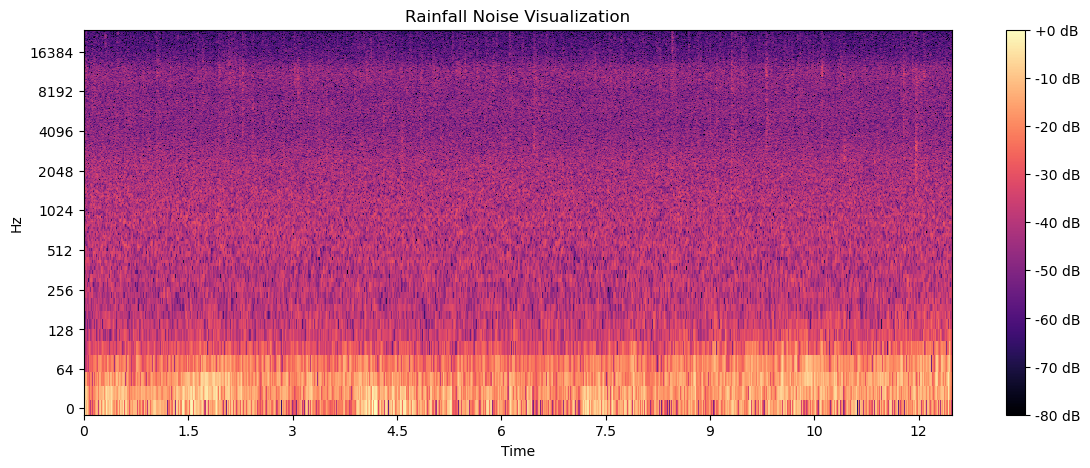

In [54]:
# rainfall noise downloaded from https://freesound.org/people/Signov/sounds/166741/
# trimmed at: https://audiotrimmer.com/
rain_noise_file = "./rainfall-trimmed.flac"
rain_noise_unfiltered, rain_noise_sr = librosa.load(rain_noise_file, sr=None, mono =True)
plot_signal(rain_noise_unfiltered, rain_noise_sr, "Rainfall Noise Visualization", spect=True)
ipd.Audio(rain_noise_unfiltered, rate=rain_noise_sr)

#### Applying High-Pass Filter
Filtering out sounds of thunder and low frequency rumbling from rain noise using a high-pass filter

In [55]:
### CHATGPT ###
# Define the cutoff frequency for the high-pass filter
cutoff_freq = 100  # Cutoff frequency in Hz

# Calculate Nyquist frequency
nyquist = 0.5 * rain_noise_sr

# Normalize the cutoff frequency
normal_cutoff = cutoff_freq / nyquist

# Design the high-pass filter
b, a = signal.butter(1, normal_cutoff, btype='high', analog=False)

# Apply the filter
rain_noise_filtered = signal.filtfilt(b, a, rain_noise_unfiltered)
### CHATGPT ###

#### After High-Pass Filter

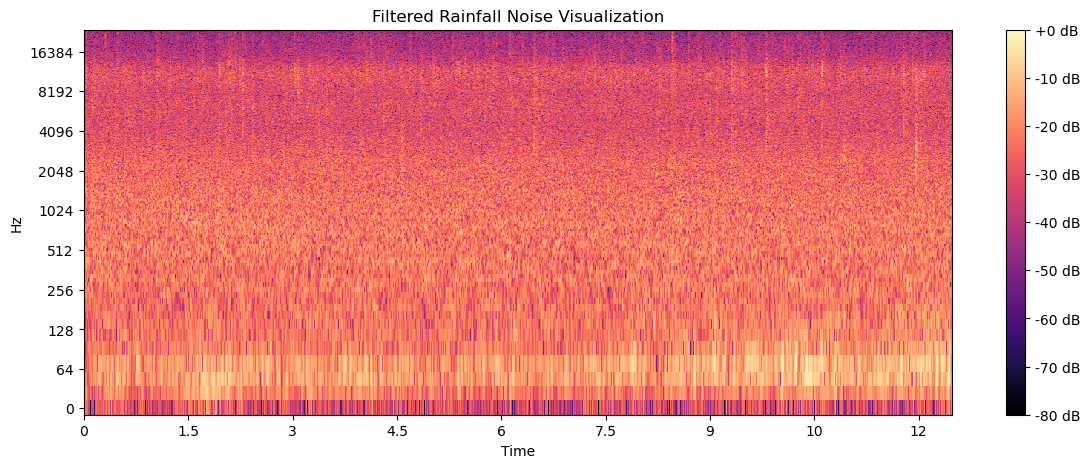

In [56]:
plot_signal(rain_noise_filtered, rain_noise_sr, "Filtered Rainfall Noise Visualization", spect=True)
ipd.display(ipd.Audio(rain_noise_filtered, rate=rain_noise_sr))

In [22]:
# Uniform white noise generation function
def generate_white_noise_uniform(length):
    return np.random.uniform(-1,1,length)

In [23]:
# Normal/Gaussian white noise generation function
def generate_white_noise_normal(length):
    return np.random.normal(0, 0.5, length)

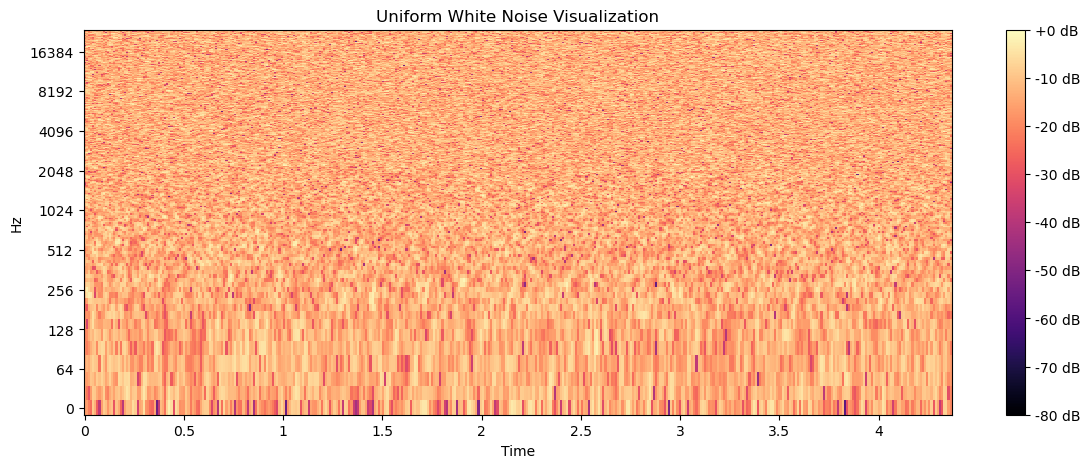

In [26]:
u = generate_white_noise_uniform(len(testfile[0]))
plot_signal(u, testfile[1], "Uniform White Noise Visualization", spect=True)
ipd.Audio(u, rate=testfile[1])

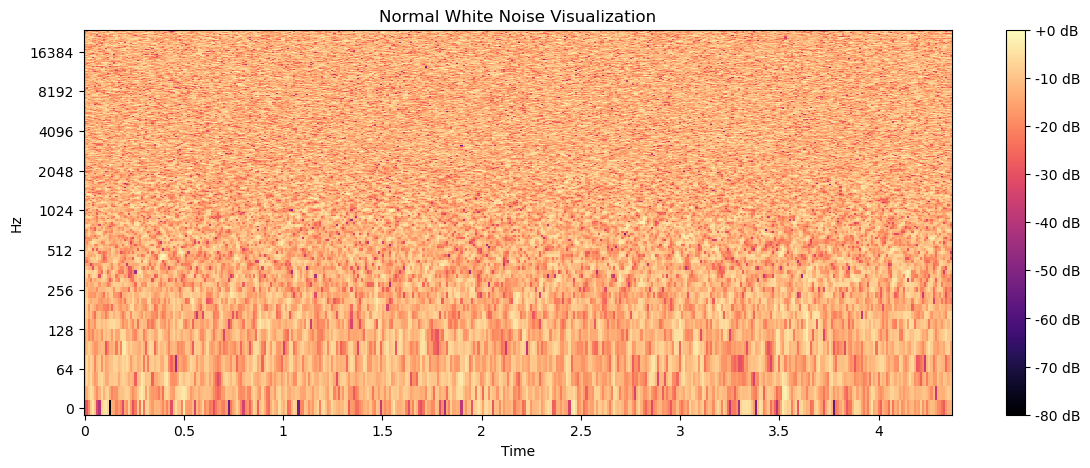

In [28]:
n = generate_white_noise_normal(len(testfile[0]))
plot_signal(n, testfile[1], "Normal White Noise Visualization", spect=True)
ipd.Audio(n, rate=testfile[1])

In [ ]:
# mixing function

def add_noise(noise_type, signal, snr=1):
    
    digital_signal = copy.deepcopy(signal[1])
    sample_rate = signal[2]
    signal_len = len(digital_signal)
    filename = signal[0]
    
    if noise_type == 'u':
        noise = generate_white_noise_uniform(signal_len)
    elif noise_type == 'n':
        noise = generate_white_noise_normal(signal_len)
    else:
        noise, _ = librosa.load(rain_noise_file, sr=None, mono =True)
        start = len(noise)//6
        end = start + signal_len
        noise = np.array(noise[start:end])
    
    # scaling noise down to RAVDESS overall average power level
    noise_avgpwr_scale = math.sqrt( (overall_P_avg*signal_len) / sum(noise**2))
    noise *= noise_avgpwr_scale
    
    if (snr >= 0):
        scale_factor = math.sqrt( (10**(-snr/10)) )
        noise *= scale_factor
        print(f'snr = {snr}, scale factor = {scale_factor}, scaling noise')
    else:
        scale_factor = math.sqrt( (10**(snr/10)) )    
        digital_signal *= scale_factor
        print(f'snr = {snr}, scale factor = {scale_factor}, scaling signal')
    
    print(f"noise power level = {sum(noise**2)/len(noise)}")
    print(f"signal power level = {sum(digital_signal**2)/signal_len}")

    noisy_audio = noise + digital_signal
        
    return [noisy_audio, sample_rate, filename]
    

In [ ]:
# generating noisy audio
choice = input("Enter 'w' for for uniform white noise, 'n' for normally distributed white noise or 'r' for rain noise:")

In [ ]:
# requesting desired noise percentage
    # noise not audible at 55dB snr
    # signal not audible at -30dB snr
    # dB range is thus 55 - (-30) = 85 
    # so 0% noise should be 55 - (0 * 85)
    # and say 30% noise should be 55 - (0.3 * 85)
    
percentage = int(input("Please enter the desired noise percentage (0-100):"))/100
snr = 55 - (percentage * 85)

noisy_audio = add_noise(choice, testfile, snr=snr)    
plot_signal(noisy_audio[1], noisy_audio[2], "Noisy Audio Signal", spect=True)
sf.write("./output/noisy_audio.wav", noisy_audio[1], noisy_audio[2])

print("Original Audio:")
display(ipd.Audio("./output/original_audio.wav"))

print("Scaled Audio:")
display(ipd.Audio("./output/scaled_audio.wav"))

print("Noisy Audio:")
display(ipd.Audio("./output/noisy_audio.wav"))